<a href="https://www.kaggle.com/code/mrfahrenheit1/50-startups?scriptVersionId=216545306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/startup-logistic-regression/50_Startups.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import skew
import warnings


In [3]:
data=pd.read_csv("/kaggle/input/startup-logistic-regression/50_Startups.csv")

# Data Exploration

In [4]:
print(data.head())


   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
print(data.describe())

           R&D Spend  Administration  Marketing Spend         Profit
count      50.000000       50.000000        50.000000      50.000000
mean    73721.615600   121344.639600    211025.097800  112012.639200
std     45902.256482    28017.802755    122290.310726   40306.180338
min         0.000000    51283.140000         0.000000   14681.400000
25%     39936.370000   103730.875000    129300.132500   90138.902500
50%     73051.080000   122699.795000    212716.240000  107978.190000
75%    101602.800000   144842.180000    299469.085000  139765.977500
max    165349.200000   182645.560000    471784.100000  192261.830000


In [7]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64


In [8]:
# cathegorical values 
data['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

# Data Preprocessing and Feature Engineering

In [9]:
# Check for multicollinearity (Variance Inflation Factor)
X = data.drop('Profit', axis=1)
y = data['Profit']

# Using OneHotEncoder for categorical features
categorical_features = ['State']
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') # sparse=False for dense output
encoded_categorical_features = onehot_encoder.fit_transform(X[categorical_features])
encoded_categorical_features_df = pd.DataFrame(encoded_categorical_features, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Combine numerical and encoded categorical features
X = pd.concat([X.drop(categorical_features, axis=1), encoded_categorical_features_df], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\nVIF values:\n", vif_data)


VIF values:
            feature       VIF
0        R&D Spend  8.451019
1   Administration  4.950277
2  Marketing Spend  8.092278
3    State_Florida  2.004519
4   State_New York  1.928836


Some options for handeling high VIF:
1. combining the two features with sum, avrageor multiplication
2. log tranformation of the features
3. applying cpa transfomation
4. using ridge and lasso
   

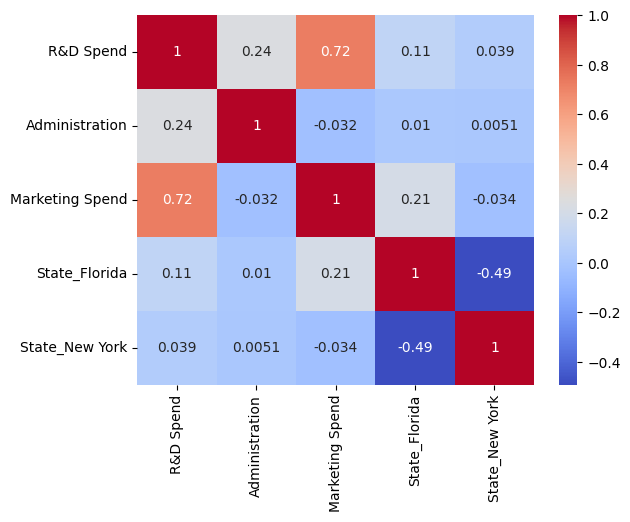

In [10]:
#Confirming R&D Spend and Marketing Spend are highy correlated 
correlation_matrix = X.corr()
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Check for skewness
numerical_cols = data.select_dtypes(include=np.number).columns.drop('Profit')
skewed_cols = data[numerical_cols].apply(lambda x: skew(x))
skewed_cols = skewed_cols[abs(skewed_cols) > 0.5]
print("\nSkewed features:\n", skewed_cols)


Skewed features:
 Series([], dtype: float64)


# Create preprocessing pipelines

In [12]:

X = data.drop('Profit', axis=1)
y = data['Profit']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

In [13]:

numerical_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1))
])


categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)])

# Feature Engineering: Polynomial Features (after preprocessing)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)



full_pipeline = Pipeline([
    ('preprocessor', preprocessor)
    
])

X_processed = full_pipeline.fit_transform(X)


# Model Training and Evaluation with Cross-Validation

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

param_grids = {
    "Ridge Regression": {'alpha': np.logspace(-3, 3, 7)},
    "Lasso Regression": {'alpha': np.logspace(-4, 0, 5)},
    "Elastic Net": {'alpha': np.logspace(-4, 0, 5), 'l1_ratio': [0.1, 0.5, 0.9]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 4, 5]},
    "SVR": {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        results[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        results[name] = model.fit(X_train, y_train) #Fit on full training set for consistent evaluation
        print(f"Cross-validation MSE for {name}: {-scores.mean()}")

Cross-validation MSE for Linear Regression: 333144067.2574359
Best parameters for Ridge Regression: {'alpha': 10.0}
Best parameters for Lasso Regression: {'alpha': 1.0}
Best parameters for Elastic Net: {'alpha': 1.0, 'l1_ratio': 0.5}
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best parameters for SVR: {'C': 10, 'gamma': 'scale'}


# Model Evaluation on Test Set

In [15]:
print("\nEvaluation on Test Set:")
for name, model in results.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name}:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R-squared: {r2}")


Evaluation on Test Set:
Linear Regression:
  MSE: 248309911.30173913
  MAE: 12550.950115355343
  R-squared: 0.6933658412236192
Ridge Regression:
  MSE: 220219344.74867916
  MAE: 11738.249575237343
  R-squared: 0.7280544575555004
Lasso Regression:
  MSE: 248298990.0012292
  MAE: 12552.332563232358
  R-squared: 0.693379327772654
Elastic Net:
  MSE: 202499744.60795686
  MAE: 11283.192868390048
  R-squared: 0.7499361241169356
Random Forest:
  MSE: 312056447.3480479
  MAE: 14083.930040000016
  R-squared: 0.6146462067434821
Gradient Boosting:
  MSE: 227169637.42082804
  MAE: 11583.138020749242
  R-squared: 0.7194716461179648
SVR:
  MSE: 951995334.6122034
  MAE: 22777.882859778056
  R-squared: -0.1756046589422131


# Visualization (Residual Plot)

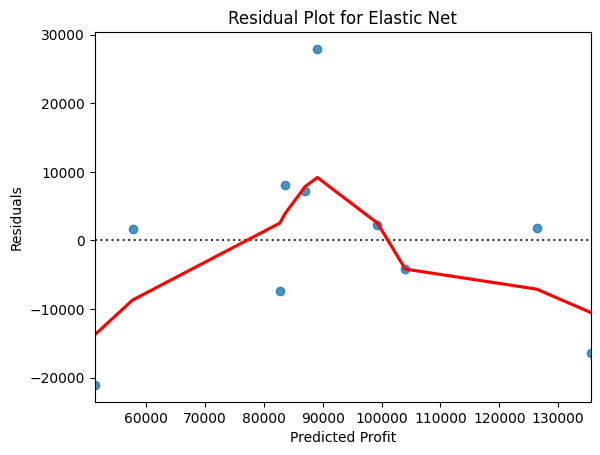

In [16]:

best_model_name = min(results, key=lambda k: mean_squared_error(y_test, results[k].predict(X_test)))
best_model = results[best_model_name]
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best
sns.residplot(x=y_pred_best, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Profit')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {best_model_name}')
plt.show()